**Notebook Contents**
- [Imports](#Imports)
- [Data import](#Data-imports)
- [Categorizing columns](#Categorizing-Columns)
- [Analyzing Target (Sale Price)](#Analyzing-Sale-Price)
- [Base Predictions](#Base-predictions)
- [Prediction using Linear Regression](#Prediction-using-Linear-Regression)

# Imports

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from PredMetric.PMetrics import PredictionMetrics

plt.style.use('dark_background')

# Data imports

In [314]:
train = pd.read_csv("./interim_datasets/train_interim.csv")
kaggle = pd.read_csv("./interim_datasets/kaggle_interim.csv")

# Categorizing Columns

In [315]:
nominal_cols = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood","Condition 1","Condition 2","Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature"]
ordinal_cols = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", "Paved Drive", "Pool QC", "Fence"]
continuous_cols = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"]
discrete_cols = ["Year Built", "Year Remod/Add", "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Bedroom abvgr", "Kitchen abvgr", "totrms abvgrd", "Fireplaces", "Garage Yr Blt", "Garage Cars", "Mo Sold" ,"Yr Sold"]

In [316]:
def convert(x):
    return x.lower().replace(" ", "_")

nominal_con_cols = [convert(x) for x in nominal_cols]
ordinal_con_cols = {convert(x):{} for x in ordinal_cols}
continuous_con_cols = [convert(x) for x in continuous_cols]
discrete_con_cols = [convert(x) for x in discrete_cols]

# Analyzing Sale Price

### Target or the value that needs to be predicted is the Sale Price. Checking the shape of the sale price. More its normalised, closer  the predicted value will be to the actual

In [317]:
train["saleprice"].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

###### The Sale Price is heavily right skewed.  Skewness = 3 * (mean-median)/ standard deviation

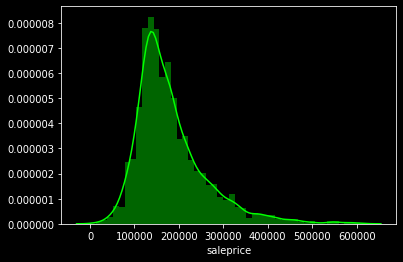

In [318]:
sns.distplot(train["saleprice"], color="lime");

In [319]:
mu = train["saleprice"].mean()
median = train["saleprice"].median()
sigma = train["saleprice"].std()
skew = 3 * (mu - median) / sigma
print("What we want is a skew value as close to 0 as possible")
print("In this case , the skew is positive(right skewed): {}".format(skew))

What we want is a skew value as close to 0 as possible
In this case , the skew is positive(right skewed): 0.7180175048622637


Checking all the houses that had a sale price of more than 500_000.  There is no reason to believe that any of the below data is incorrect.

In [320]:
train.loc[train["saleprice"] > 500_000, ["year_built", "overall_qual", "gr_liv_area", "neighborhood", "saleprice"]]

,year_built,overall_qual,gr_liv_area,neighborhood,saleprice
81,2008,9,2234,StoneBr,501837
138,2006,10,3390,StoneBr,545224
151,2005,9,2868,StoneBr,556581
623,2004,10,2492,NridgHt,552000
800,2007,10,2290,NridgHt,500067
823,2003,8,3279,StoneBr,538000
1164,2008,10,2402,NridgHt,555000
1592,2006,10,2698,StoneBr,535000
1671,2009,9,2364,NridgHt,611657
1692,1993,9,3500,NoRidge,584500


Steps to normalize a right skewed data so we can make better predictions

In [321]:
train["log_saleprice"] = train["saleprice"].map(np.log)
mu = train["log_saleprice"].mean()
median = train["log_saleprice"].median()
sigma = train["log_saleprice"].std()
skew = 3 * (mu - median) / sigma
print("What we want is a skew value as close to 0 as possible")
print("After taking log of the Sales Price, the skew is : {}".format(skew))

What we want is a skew value as close to 0 as possible
After taking log of the Sales Price, the skew is : 0.18936988229409515


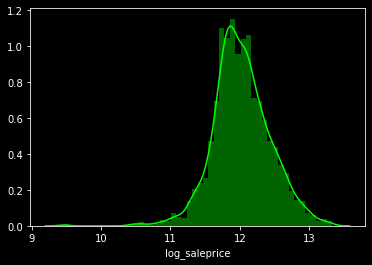

In [322]:
sns.distplot(train["log_saleprice"], color="lime");

In [323]:
train["log_saleprice"].describe()

count    2051.000000
mean       12.024397
std         0.411316
min         9.456341
25%        11.773943
50%        11.998433
75%        12.273731
max        13.323927
Name: log_saleprice, dtype: float64

# Base predictions 

In [324]:
print("Naive prediction is the mean of the sales price is : {}".format(train["saleprice"].mean()))

Naive prediction is the mean of the sales price is : 181469.70160897123


In [325]:
sale_price_mean_column = np.array([train["saleprice"].mean()] * train.shape[0])

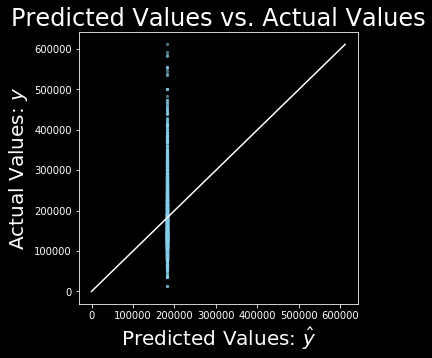

In [326]:
#Plotting the naive model 
plt.figure(figsize=(5,5))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(sale_price_mean_column, train["saleprice"], s=5, color='skyblue', alpha = 0.5)

sns.lineplot([0, np.max(train["saleprice"])], [0, np.max(train["saleprice"])], color="white")

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

# METRICS

In [327]:
mse = mean_squared_error(train["saleprice"], sale_price_mean_column)
rmse = mean_squared_error(train["saleprice"], sale_price_mean_column) ** (1/2)
r2_score_value = r2_score(train["saleprice"],sale_price_mean_column )
residuals = abs(train["saleprice"] - sale_price_mean_column)
print("Mean Squared Error : {}".format(mse))
print("Root Mean Squared Error : {}".format(rmse))
print("R2 score : {}".format(r2_score_value))
print("Residuals mean : {}".format(residuals.mean()))

Mean Squared Error : 6278872217.837828
Root Mean Squared Error : 79239.33504161824
R2 score : 0.0
Residuals mean : 58358.94084226186


#### Plotting residuals

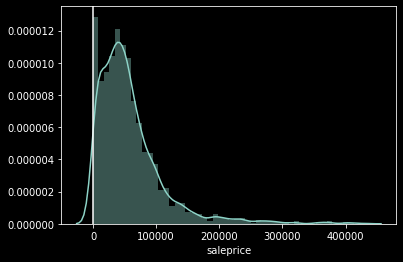

In [328]:
sns.distplot(residuals)
plt.axvline(0, color="white");

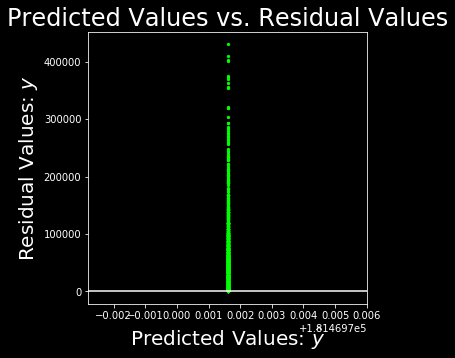

In [329]:
# Plot the model
plt.figure(figsize=(5,5))
# Generate a scatterplot of predicted values versus actual values.
plt.scatter(sale_price_mean_column, residuals, s=5, color='lime')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Residual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Residual Values', fontsize = 24);
plt.axhline(0, color="white");

##### Inferences from the above

The above model has a very high level of error. The predicted and the actual values are no way close . 
Residuals are not normally distributed.  if mean value is used, chances of getting every prediction wrong is pretty much 100%

# Prediction using Linear Regression

##### Checking the distribution of each feature in relation to the Sale Price. Need to know if there are outliers.

##### Starting with continuous distribution columns

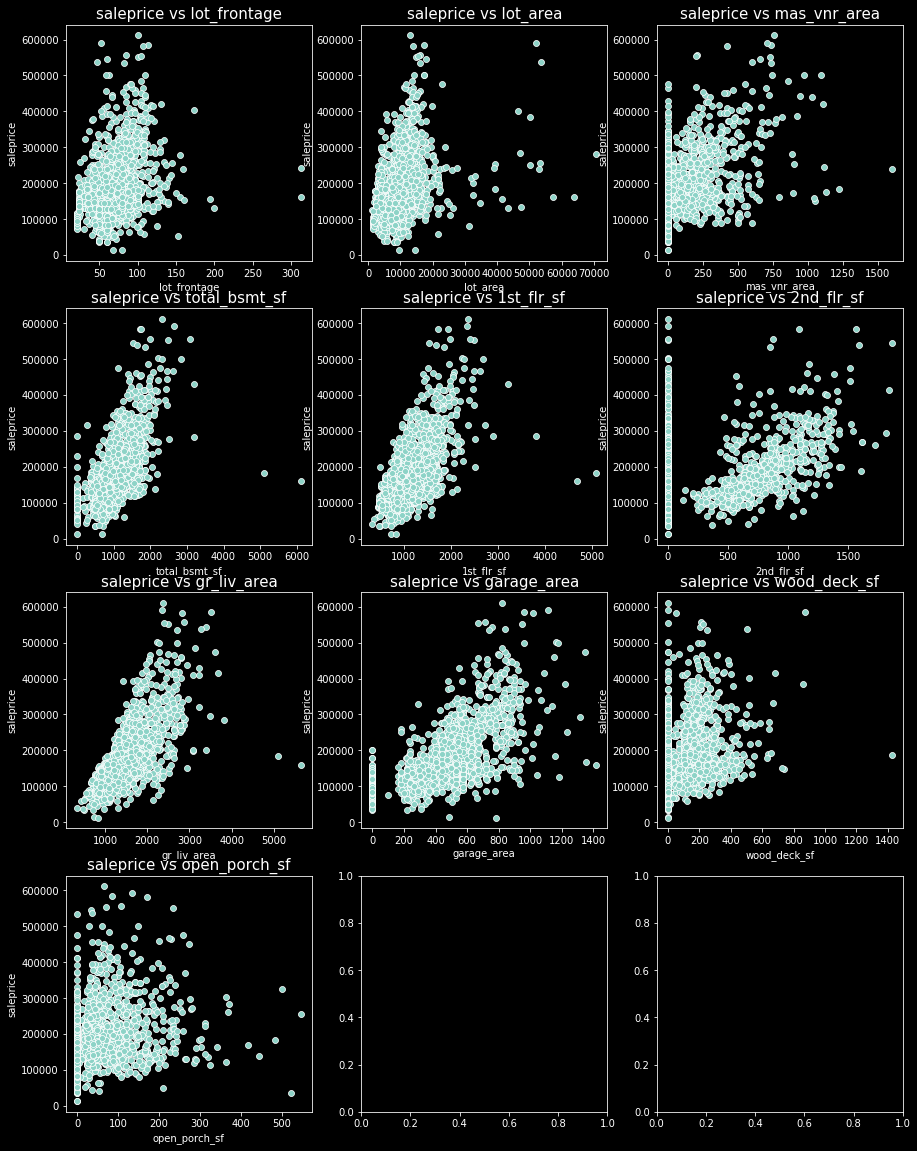

In [330]:
features_continuous = ["lot_frontage", "lot_area", "mas_vnr_area",  "total_bsmt_sf", "1st_flr_sf", "2nd_flr_sf", "gr_liv_area", "garage_area", "wood_deck_sf", "open_porch_sf"]
nrows = int(np.ceil(len(features_continuous)/3)) 
fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (15,5*nrows)) 
ax = ax.ravel() 
i = 0
for col in features_continuous:
    X = train[col]
    sns.scatterplot(X, train["saleprice"],ax=ax[i])
    ax[i].set_title("saleprice vs " + col , size=15)
    i += 1


##### Checking for outliers : To see if anything can be changed to get a better line of best fit.

Looks like few values are way out than the remaining values

In [331]:
outliers = ((train['saleprice'] < 300_000) & (train['lot_frontage'] > 180)) | ((train['saleprice'] > 550_000) & (train['lot_frontage'] < 100))
train.loc[outliers, :].sort_values(by="lot_frontage", ascending=False)

,Unnamed: 0,Id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,dummis_na,dummis_othr,dummis_shed,dummis_tenc,bin_year_built,bin_year_remod/add,bin_total_baths,bin_garage_yr_blt,log_lot_frontage,log_saleprice
960,960,1499,908154235,60,RL,313.0,63887.0,Pave,NaN,1,...,1,0,0,0,2000,2000,4.5,2000,5.746203,11.982929
1335,1335,1266,535427070,20,RL,313.0,27650.0,Pave,NaN,2,...,1,0,0,0,1900,2000,3.0,1900,5.746203,12.396693
1875,1875,2279,923202220,20,RL,200.0,43500.0,Pave,NaN,4,...,1,0,0,0,1900,1900,1.0,1900,5.298317,11.775290
441,441,1639,527226040,190,RL,195.0,41600.0,Pave,NaN,3,...,1,0,0,0,1900,1900,2.5,1900,5.273000,11.951180
151,151,2333,527212030,60,RL,85.0,16056.0,Pave,NaN,3,...,1,0,0,0,2000,2000,3.5,2000,4.442651,13.229568
1964,1964,1638,527216080,20,RL,52.0,51974.0,Pave,NaN,3,...,1,0,0,0,2000,2000,3.5,2000,3.951244,13.290564


###### Modeling

In [332]:
X_col = "lot_frontage"
y_col = "saleprice"

In [333]:
y = train[y_col]
X = train[[X_col]]
X_out = train[[X_col]].drop([960, 1885, 1875, 1335, 441, 151, 1964], axis=0)
y_out = train[y_col].drop([960, 1885, 1875, 1335, 441, 151, 1964], axis=0)

In [334]:
lr = LinearRegression()
lr.fit(X,y)

print(lr.score(X,y))

0.11422941526672026


In [335]:
lr_out = LinearRegression()
lr_out.fit(X_out,y_out)
y_hat = lr.predict(X_out)
y_out_hat = lr_out.predict(X_out)
print(lr_out.score(X_out,y_out))

0.1381450668823564


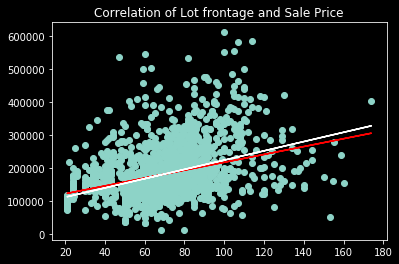

In [336]:
plt.scatter(X_out, y_out)
plt.title("Correlation of Lot frontage and Sale Price")
plt.plot(X_out, y_hat, color="r")
plt.plot(X_out, y_out_hat, color="w");

# Cannot remove observations based on outliers since that will result in overfitting and may not hold true for the population

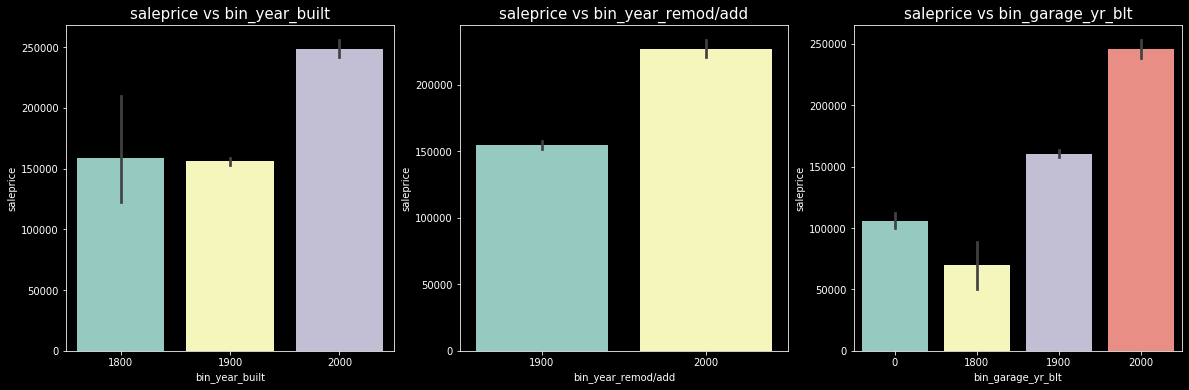

In [337]:
features_discrete_bins = list(train.filter(regex="bin").columns) 
features_discrete_bins.remove("bin_total_baths")
nrows = int(np.ceil(len(features_discrete_bins)/3)) 
fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (20,6*nrows)) 
ax = ax.ravel() 
i = 0
for col in features_discrete_bins:
    sns.barplot(train[col], train["saleprice"],ax=ax[i])
    ax[i].set_title("saleprice vs " + col , size=15)
    i += 1

In [338]:
features_nominal = nominal_con_cols
# nrows = int(np.ceil(len(features_nominal)/3)) 
# fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (20,6*nrows)) 
# ax = ax.ravel() 
# i = 0
# for col in features_nominal:
#     sns.barplot(train[col], train["saleprice"],ax=ax[i])
#     ax[i].set_title("saleprice vs " + col , size=15)
#     i += 1

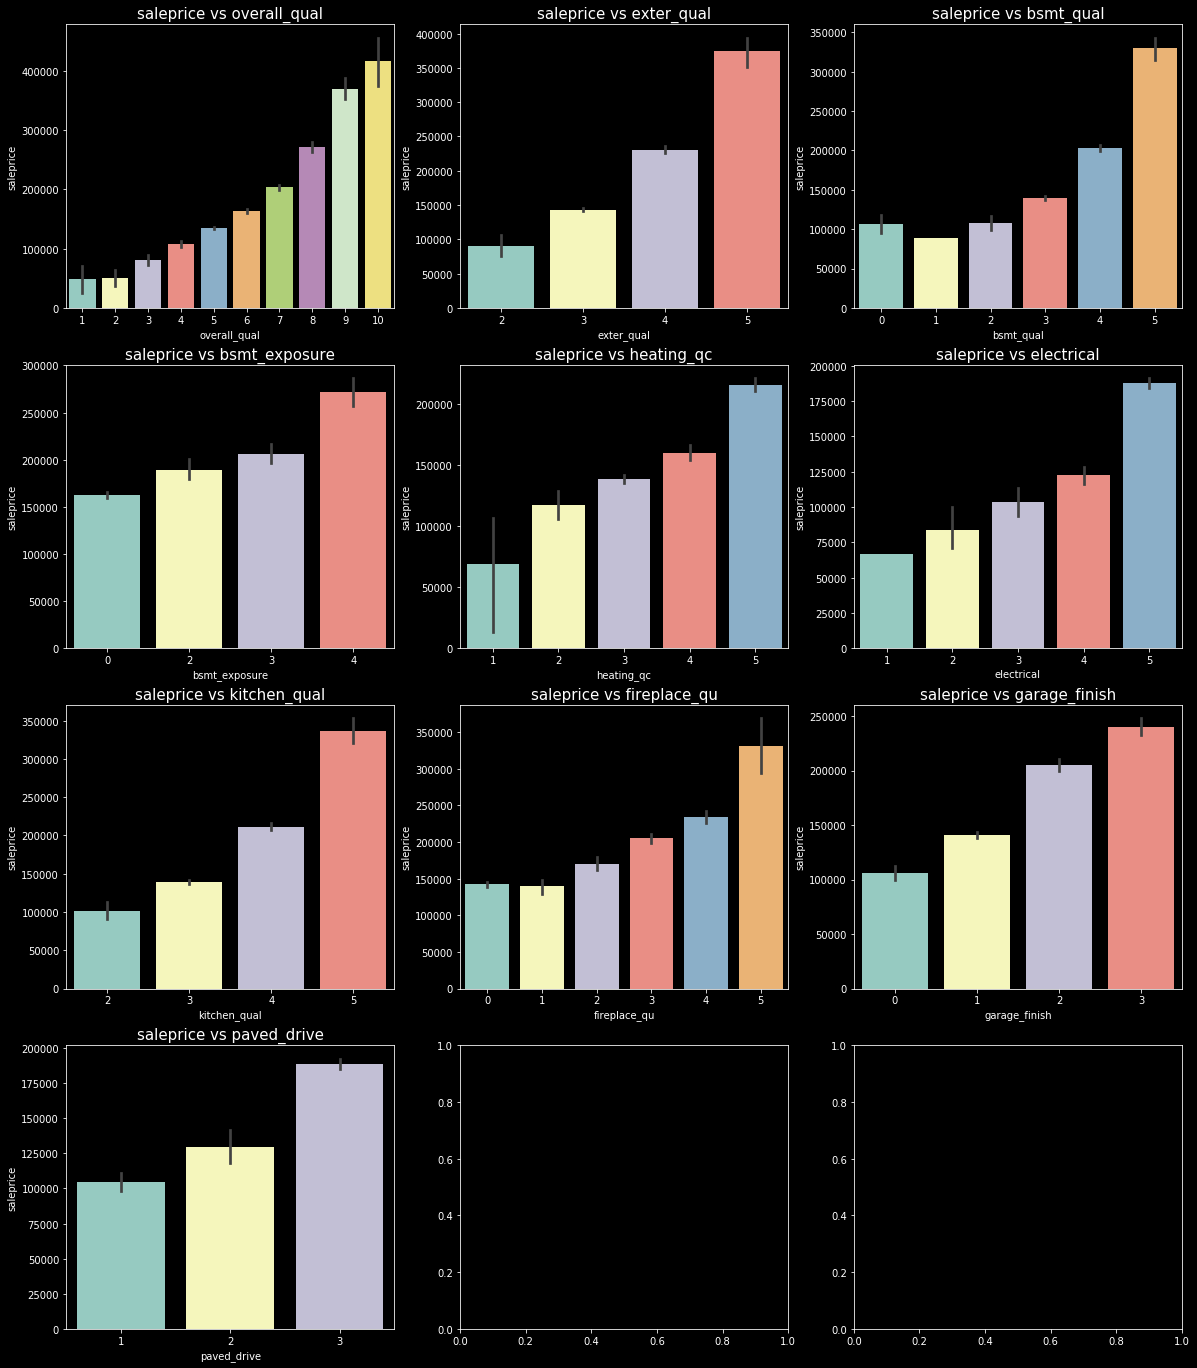

In [339]:
features_ordinal = ["overall_qual", "exter_qual", "bsmt_qual", "bsmt_exposure", "heating_qc", "electrical", "kitchen_qual", "fireplace_qu", "garage_finish", "paved_drive"]
nrows = int(np.ceil(len(features_ordinal)/3)) 
fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (20,6*nrows)) 
ax = ax.ravel() 
i = 0
for col in features_ordinal:
    sns.barplot(train[col], train["saleprice"],ax=ax[i])
    ax[i].set_title("saleprice vs " + col , size=15)
    i += 1

In [340]:
features = ["saleprice", "bin_total_baths", "totrms_abvgrd", "fireplaces"] + features_continuous + features_discrete_bins + features_ordinal + list(train.filter(regex="dum").columns)

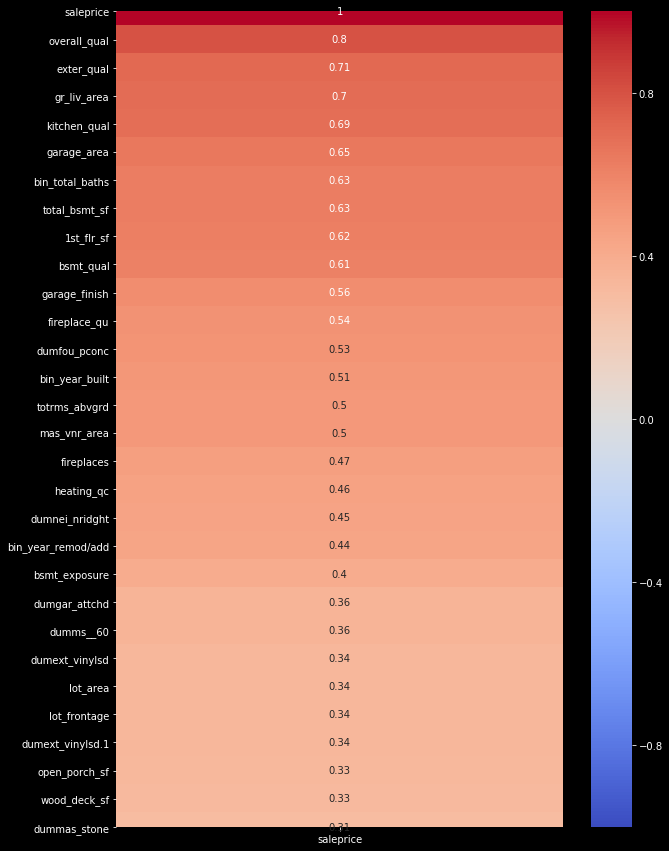

In [341]:
plt.figure(figsize=(10,15))
sns.heatmap(train[features].corr()[['saleprice']][train[features].corr()['saleprice'] > 0.30].sort_values(by='saleprice', ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

In [342]:
final_features = list(train[features].corr()[['saleprice']][train[features].corr()['saleprice'].abs() >= 0.20].sort_values(by='saleprice', ascending=False).index)
final_features.remove("saleprice")
print("Total features selected for predicting sale price : {}".format(len(final_features)))

Total features selected for predicting sale price : 52


# PREDICTIONS WITH LR TRIAL2

# A. SELECTION OF FEATURES

### Although from co-relation point of view , few features are valid. I would like to start with all the features and then reduce and check the results

In [343]:
##Although from co-relation point of view , few features are valid. I would like to start with all the features and then
###reduce and check the results
###Every data point given
all_columns = list(train.filter(regex="dum")) + \
              list(ordinal_con_cols.keys()) + continuous_con_cols + \
              list(train.filter(regex="bin")) + \
              ["totrms_abvgrd", "fireplaces", "garage_yr_blt", "garage_cars", "mo_sold", "yr_sold", "full_bath"]
                  
all_columns.sort()
###checked for few features to be included for initial prediction for a LR model
revised_features = ['1st_flr_sf',
 'bin_total_baths',
 'bin_year_built',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_qual',
 'bsmtfin_sf_1',
 'dumcon_posa.1',
 'dumext_brkface',
 'dummis_elev',
 'dummis_tenc',
 'dumms__20',
 'dumms__60',
 'dumnei_grnhill',
 'dumnei_noridge',
 'dumnei_nridght',
 'dumnei_nwames',
 'dumnei_stonebr',
 'dumroo_wdshngl',
 'exter_qual',
 'functional',
 'garage_area',
 'gr_liv_area',
 'kitchen_qual',
 'lot_area',
 'mas_vnr_area',
 'overall_qual',
 'screen_porch',
 'total_bsmt_sf']

# B. MODEL

In [344]:
X = train[revised_features]
y = train["saleprice"]
##Splitting the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# C. PLOTTING

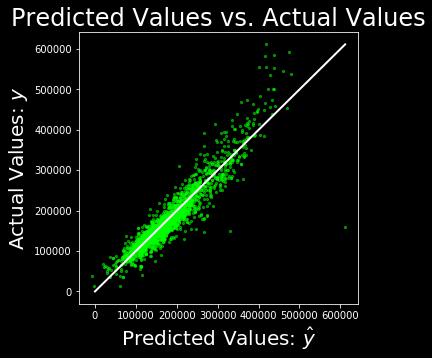

In [345]:
#Plotting 1st LR prediction model
plt.figure(figsize=(5,5))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(lr.predict(X), train["saleprice"], s=5, color='lime', alpha = 0.5)

##Absolute 
sns.lineplot([0, np.max(train["saleprice"])], [0, np.max(train["saleprice"])], color="white", linewidth=2)

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

# D. METRICS

In [346]:
pm = PredictionMetrics(lr, X_train, X_test, y_train, y_test)
pm.metric_df

,Scores,Train,Test,Result,Percent
0,lr.score,0.866006,0.893634,Train < Test,-3.09162
1,r2_score,0.866006,0.893634,Train < Test,-3.09162
2,mean cross_val_score,0.798059,0.895572,Train < Test,-10.8884
3,mean_squared_error,8.63782e+08,6.3131e+08,Train > Test,36.8238
4,root mean squared error,29390.2,25125.9,Train > Test,16.9717
5,residual mean,18705.3,18504.4,Train > Test,1.08564
6,cross_val_score,"[0.851, 0.853, 0.897, 0.828, 0.561]","[0.909, 0.898, 0.884, 0.892, 0.895]",NaN,NaN


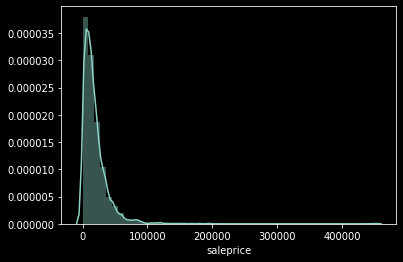

In [347]:
residulals = abs(y - lr.predict(X))
sns.distplot(residulals);

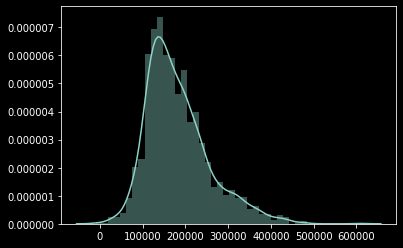

In [348]:
sns.distplot(lr.predict(X));

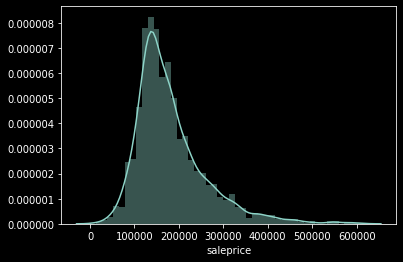

In [349]:
sns.distplot(train["saleprice"]);

In [350]:
ols_X = sm.add_constant(X_train)
model_ols = sm.OLS(y_train,ols_X).fit()
model_ols.summary().tables[0]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,saleprice,R-squared:,0.866
Model:,OLS,Adj. R-squared:,0.863
Method:,Least Squares,F-statistic:,299.5
Date:,"Wed, 15 Jan 2020",Prob (F-statistic):,0.00
Time:,22:05:00,Log-Likelihood:,-16086.
No. Observations:,1374,AIC:,3.223e+04
Df Residuals:,1344,BIC:,3.239e+04
Df Model:,29,,
Covariance Type:,nonrobust,,


# E. PREDICTING FOR KAGGLE USING THE MODEL

In [351]:
##adding the columns missing in kaggle
for cols in revised_features:
    if cols not in kaggle.columns:
        kaggle[cols] = 0

prediction_data = kaggle[revised_features]
kaggle_preds = lr.predict(prediction_data)
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [352]:
kaggle_predictions["SalePrice"].std()

72284.12010652004

In [353]:
kaggle_predictions["SalePrice"].describe()

count       878.000000
mean     179346.448710
std       72284.120107
min        7634.517043
25%      128509.600838
50%      162655.872184
75%      218940.013827
max      566939.652550
Name: SalePrice, dtype: float64

In [354]:
kaggle_predictions.to_csv("./submissions/2-features-predictions.csv", index=False)

In [355]:
train["salesprice_hat"] = lr.predict(X)
train["salesprice_hat"].describe()

count      2051.000000
mean     181778.722067
std       74201.552505
min       -8467.676227
25%      129092.095853
50%      167146.955038
75%      219634.936414
max      610852.610097
Name: salesprice_hat, dtype: float64

In [356]:
train["residuals"] = abs(train["saleprice"] - train["salesprice_hat"])
train.loc[train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
4,138500,130004.478093,8495.521907
7,142000,149536.085611,7536.085611
8,112500,118759.932846,6259.932846
12,131000,137541.920878,6541.920878
17,139000,134406.980776,4593.019224
...,...,...,...
2043,128000,124300.304452,3699.695548
2044,182000,186617.947269,4617.947269
2047,82500,87970.763003,5470.763003
2048,177000,169767.783992,7232.216008


# 2. PREDICTIONS WITH LR - TRIAL 3 (USING SALE PRICE LOG)

In [357]:
##Features:
revised_features = ['1st_flr_sf',
 'bin_total_baths',
 'bin_year_built',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_qual',
 'bsmtfin_sf_1',
 'dumcon_posa.1',
 'dumext_brkface',
 'dummis_elev',
 'dummis_tenc',
 'dumms__20',
 'dumms__60',
 'dumnei_grnhill',
 'dumnei_noridge',
 'dumnei_nridght',
 'dumnei_nwames',
 'dumnei_stonebr',
 'dumroo_wdshngl',
 'exter_qual',
 'functional',
 'garage_area',
 'gr_liv_area',
 'kitchen_qual',
 'lot_area',
 'mas_vnr_area',
 'overall_qual',
 'screen_porch',
 'total_bsmt_sf']

# B. MODEL

In [358]:
X = train[revised_features]
y = train["saleprice"].map(np.log)
##Splitting the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

# C. PLOTTING

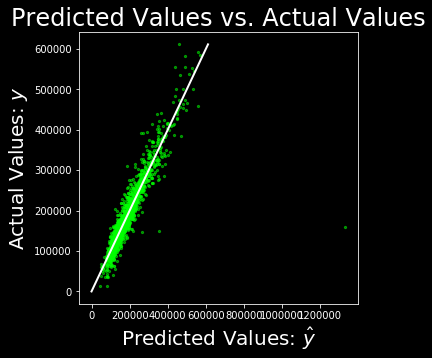

In [359]:
#Plotting 2nd LR prediction model
plt.figure(figsize=(5,5))

y_hat = np.exp(lr.predict(X))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, train["saleprice"], s=5, color='lime', alpha = 0.5)

##Absolute 
sns.lineplot([0, np.max(train["saleprice"])], [0, np.max(train["saleprice"])], color="white", linewidth=2)

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

# D. METRICS

In [360]:
pm = PredictionMetrics(lr, X_train, X_test, y_train, y_test,True)
pm.metric_df

,Scores,Train,Test,Result,Percent
0,lr.score,-5.06537,-5.64166,Train > Test,-10.215
1,r2_score,0.760179,0.913862,Train < Test,-16.8168
2,mean cross_val_score,0.798059,0.895572,Train < Test,-10.8884
3,mean_squared_error,1.54599e+09,5.11256e+08,Train > Test,202.391
4,root mean squared error,39319.1,22611,Train > Test,73.894
5,residual mean,17036.4,16256.6,Train > Test,4.79709
6,cross_val_score,"[0.851, 0.853, 0.897, 0.828, 0.561]","[0.909, 0.898, 0.884, 0.892, 0.895]",NaN,NaN


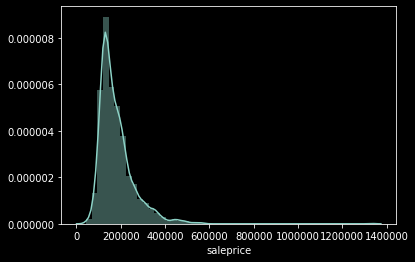

In [361]:
residulals = abs(y - np.exp(lr.predict(X)))
sns.distplot(residulals);

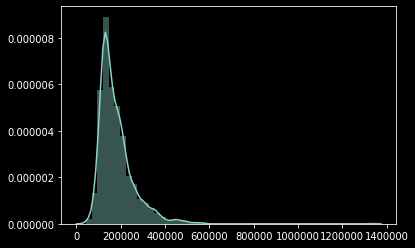

In [362]:
sns.distplot(np.exp(lr.predict(X)));

In [363]:
ols_X = sm.add_constant(X_train)
model_ols = sm.OLS(y_train.map(np.log),ols_X).fit()
model_ols.summary().tables[0]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,saleprice,R-squared:,0.865
Model:,OLS,Adj. R-squared:,0.862
Method:,Least Squares,F-statistic:,297.9
Date:,"Wed, 15 Jan 2020",Prob (F-statistic):,0.00
Time:,22:05:01,Log-Likelihood:,650.62
No. Observations:,1374,AIC:,-1241.
Df Residuals:,1344,BIC:,-1084.
Df Model:,29,,
Covariance Type:,nonrobust,,


# E. PREDICTING FOR KAGGLE USING THE MODEL

In [364]:
##adding the columns missing in kaggle
for cols in revised_features:
    if cols not in kaggle.columns:
        kaggle[cols] = 0

prediction_data = kaggle[revised_features]
kaggle_preds = np.exp(lr.predict(prediction_data))
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [365]:
kaggle_predictions["SalePrice"].std()

77086.42650933465

In [366]:
kaggle_predictions["SalePrice"].describe()

count       878.000000
mean     176979.579790
std       77086.426509
min       54894.127879
25%      126047.870975
50%      155114.368241
75%      210796.792614
max      724879.193382
Name: SalePrice, dtype: float64

In [367]:
kaggle_predictions.to_csv("./submissions/3-features-predictions.csv", index=False)

In [368]:
train["salesprice_hat"] = np.exp(lr.predict(X))
train["salesprice_hat"].describe()

count    2.051000e+03
mean     1.800291e+05
std      7.980551e+04
min      4.330106e+04
25%      1.273124e+05
50%      1.594088e+05
75%      2.100223e+05
max      1.331652e+06
Name: salesprice_hat, dtype: float64

In [369]:
train["residuals"] = abs(train["saleprice"] - train["salesprice_hat"])
train.loc[train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
4,138500,139630.759325,1130.759325
5,190000,196499.116117,6499.116117
7,142000,139632.925458,2367.074542
8,112500,120144.019634,7644.019634
13,200000,205613.316832,5613.316832
...,...,...,...
2040,225000,224703.046745,296.953255
2041,412500,410649.368912,1850.631088
2043,128000,124159.944930,3840.055070
2044,182000,175452.247929,6547.752071


# 3. PREDICTIONS WITH LR - TRIAL 4 (USING LOG FOR FEW FIELDS)

# B. MODEL

In [370]:
revised_features_log = ['1st_flr_sf', 'bin_total_baths', 'bin_year_built', 'exter_qual', 'functional', 'gr_liv_area', 'kitchen_qual', 'lot_area', 'overall_qual']
revised_features_no_log = ['bsmt_cond', 'bsmt_exposure', 'bsmt_qual', 'bsmtfin_sf_1', 'dumcon_posa.1', 'dumext_brkface', 'dummis_elev', 'dummis_tenc', 'dumms__20', 'dumms__60', 'dumnei_grnhill', 'dumnei_noridge', 'dumnei_nridght', 'dumnei_nwames', 'dumnei_stonebr', 'dumroo_wdshngl', 'garage_area', 'mas_vnr_area', 'screen_porch', 'total_bsmt_sf']
log_ones = train[revised_features_log].apply(np.log)
X = pd.concat((train[revised_features_no_log], log_ones), axis=1)
y = train["saleprice"].map(np.log)
# ##Splitting the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

# C. PLOTTING

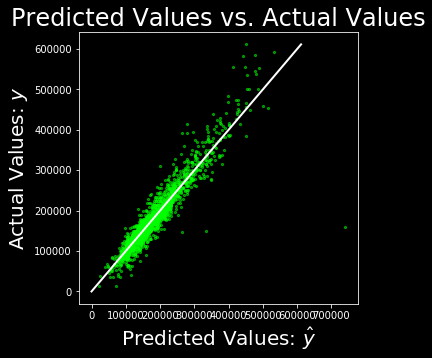

In [371]:
#Plotting 3nd LR prediction model
plt.figure(figsize=(5,5))

y_hat = np.exp(lr.predict(X))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, train["saleprice"], s=5, color='lime', alpha = 0.5)

##Absolute 
sns.lineplot([0, np.max(train["saleprice"])], [0, np.max(train["saleprice"])], color="white", linewidth=2)

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

# D. METRICS

In [372]:
pm = PredictionMetrics(lr, X_train, X_test, y_train, y_test,True)
pm.metric_df

,Scores,Train,Test,Result,Percent
0,lr.score,-5.06537,-5.64166,Train > Test,-10.215
1,r2_score,0.877541,0.920832,Train < Test,-4.70132
2,mean cross_val_score,0.804922,0.876683,Train < Test,-8.18546
3,mean_squared_error,7.89425e+08,4.69882e+08,Train > Test,68.005
4,root mean squared error,28096.7,21676.8,Train > Test,29.6168
5,residual mean,16250.6,15665.8,Train > Test,3.73282
6,cross_val_score,"[0.842, 0.831, 0.869, 0.831, 0.652]","[0.892, 0.875, 0.863, 0.872, 0.882]",NaN,NaN


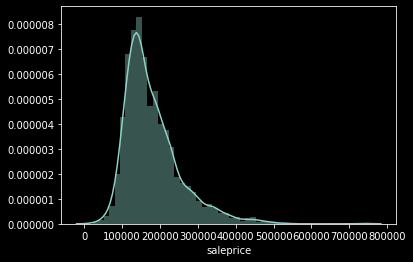

In [373]:
residulals = abs(y - np.exp(lr.predict(X)))
sns.distplot(residulals);

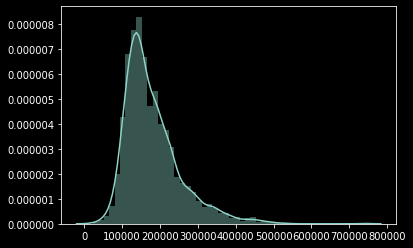

In [374]:
sns.distplot(np.exp(lr.predict(X)));

In [375]:
ols_X = sm.add_constant(X_train)
model_ols = sm.OLS(y_train.map(np.log),ols_X).fit()
model_ols.summary().tables[0]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,saleprice,R-squared:,0.889
Model:,OLS,Adj. R-squared:,0.887
Method:,Least Squares,F-statistic:,371.1
Date:,"Wed, 15 Jan 2020",Prob (F-statistic):,0.00
Time:,22:05:02,Log-Likelihood:,783.15
No. Observations:,1374,AIC:,-1506.
Df Residuals:,1344,BIC:,-1350.
Df Model:,29,,
Covariance Type:,nonrobust,,


# E. PREDICTING FOR KAGGLE USING THE MODEL

In [376]:
##adding the columns missing in kaggle
for cols in revised_features:
    if cols not in kaggle.columns:
        kaggle[cols] = 0

log_ones_kaggle = kaggle[revised_features_log].apply(np.log)
prediction_data = pd.concat((kaggle[revised_features_no_log], log_ones_kaggle), axis=1)
kaggle_preds = np.exp(lr.predict(prediction_data))
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [377]:
kaggle_predictions["SalePrice"].std()

72740.85173319421

In [378]:
kaggle_predictions["SalePrice"].describe()

count       878.000000
mean     177216.680548
std       72740.851733
min       46073.775788
25%      128012.554120
50%      156914.365965
75%      212262.922612
max      624253.030937
Name: SalePrice, dtype: float64

In [379]:
kaggle_predictions.to_csv("./submissions/4-features-predictions.csv", index=False)

In [380]:
train["salesprice_hat"] = np.exp(lr.predict(X))
train["salesprice_hat"].describe()

count      2051.000000
mean     180093.585125
std       74226.101005
min       22818.911397
25%      129573.020981
50%      161309.803075
75%      213605.077764
max      740268.007140
Name: salesprice_hat, dtype: float64

In [381]:
train["residuals"] = abs(train["saleprice"] - train["salesprice_hat"])
train.loc[train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
1,220000,229827.898159,9827.898159
4,138500,141489.757244,2989.757244
7,142000,146881.018993,4881.018993
8,112500,119619.974068,7119.974068
13,200000,191945.685145,8054.314855
...,...,...,...
2039,93900,85796.111025,8103.888975
2040,225000,229973.728792,4973.728792
2043,128000,123110.781888,4889.218112
2044,182000,179843.021718,2156.978282


# 4. PREDICTIONS WITH LR - TRIAL 5 (USING POLYNOMIAL ONLY ON REVISED COLUMNS)

## A. FEATURE SELECTION

In [456]:
revised_features = ['1st_flr_sf',
 'bin_total_baths',
 'bin_year_built',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_qual',
 'bsmtfin_sf_1',
 'dumcon_posa.1',
 'dumext_brkface',
 'dummis_elev',
 'dummis_tenc',
 'dumms__20',
 'dumms__60',
 'dumnei_grnhill',
 'dumnei_noridge',
 'dumnei_nridght',
 'dumnei_nwames',
 'dumnei_stonebr',
 'dumroo_wdshngl',
 'exter_qual',
 'functional',
 'garage_area',
 'gr_liv_area',
 'kitchen_qual',
 'lot_area',
 'mas_vnr_area',
 'overall_qual',
 'screen_porch',
 'total_bsmt_sf']

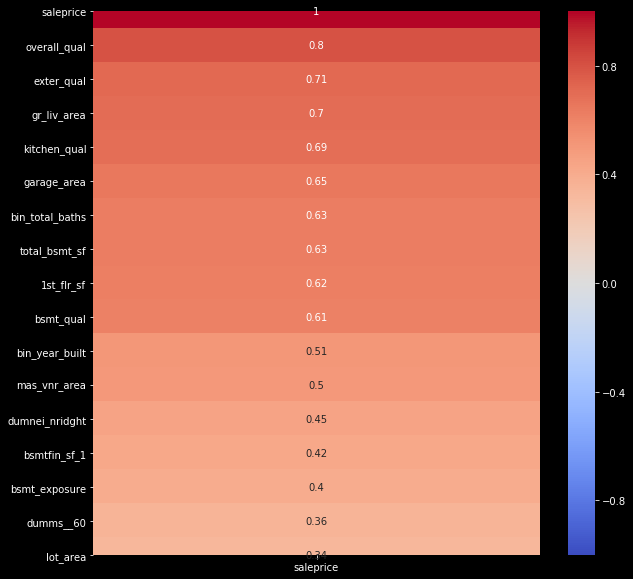

In [457]:
nf = revised_features + ["saleprice"]
plt.figure(figsize=(10,10))
sns.heatmap(train[nf].corr()[['saleprice']][train[nf].corr()['saleprice'] > 0.30].sort_values(by='saleprice', ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

In [458]:
# Instantiate PolynomialFeatures
poly = PolynomialFeatures(include_bias=False)
# Create X_poly
X = train[revised_features]
y = train["saleprice"].map(np.log)

# ##Splitting the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

X_poly = poly.fit_transform(X)
# Convert X_poly to a DataFrame
new_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(revised_features))

In [459]:
poly_revised_features = ['overall_qual^2',
 'garage_area overall_qual',
 'gr_liv_area kitchen_qual',
 '1st_flr_sf overall_qual',
 'overall_qual total_bsmt_sf',
 'bin_total_baths bsmt_qual',
 '1st_flr_sf total_bsmt_sf',
 '1st_flr_sf dumnei_nridght',
 'gr_liv_area lot_area',
 'dumnei_nridght',
 'bsmt_cond bsmtfin_sf_1',
 'bsmt_exposure lot_area',
 '1st_flr_sf lot_area',
 'dumms__60 lot_area',
 'dumms__60 functional',
 'bsmt_exposure dumms__20',
 'bsmtfin_sf_1 dumms__20',
 'dumnei_noridge lot_area',
 'functional^2',
 'dumms__20 functional',
 'dumext_brkface overall_qual',
 'dumnei_grnhill lot_area',
 'dummis_tenc screen_porch',
 'dummis_tenc overall_qual',
 'dummis_tenc functional',
 'dummis_tenc kitchen_qual',
 'dummis_tenc dumnei_nwames',
 'dummis_tenc dumms__60',
 'dummis_tenc^2',
 'bsmt_qual dummis_tenc',
 'bin_year_built dummis_tenc',
 'dummis_tenc garage_area',
 'bin_total_baths dummis_tenc',
 'dummis_tenc gr_liv_area',
 'dummis_tenc total_bsmt_sf',
 '1st_flr_sf dummis_tenc',
 'bsmtfin_sf_1 dummis_tenc',
 'dummis_tenc exter_qual',
 'bsmt_cond dummis_tenc',
 'dummis_tenc lot_area',
 'dummis_tenc mas_vnr_area']

In [460]:
revised_features_with_poly = revised_features + poly_revised_features

In [461]:
len(poly_revised_features)

41

In [462]:
X = new_poly_df[revised_features_with_poly]
y = train["saleprice"].map(np.log)

# ##Splitting the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

# C. PLOTTING

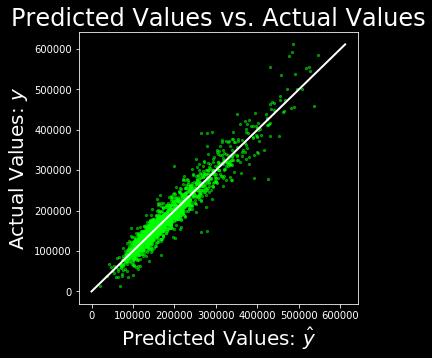

In [463]:
#Plotting 4th  LR prediction model
plt.figure(figsize=(5,5))

y_hat = np.exp(lr.predict(X))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, train["saleprice"], s=5, color='lime', alpha = 0.5)

##Absolute 
sns.lineplot([0, np.max(train["saleprice"])], [0, np.max(train["saleprice"])], color="white", linewidth=2)

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

# D. METRICS

In [464]:
pm = PredictionMetrics(lr, X_train, X_test, y_train, y_test,True)
pm.metric_df

,Scores,Train,Test,Result,Percent
0,lr.score,-5.06537,-5.64166,Train > Test,-10.215
1,r2_score,0.928104,0.919707,Train > Test,0.912993
2,mean cross_val_score,0.773415,0.914438,Train < Test,-15.4218
3,mean_squared_error,4.63476e+08,4.76562e+08,Train < Test,-2.74597
4,root mean squared error,21528.5,21830.3,Train < Test,-1.38254
5,residual mean,15138.6,15578.5,Train < Test,-2.82377
6,cross_val_score,"[0.915, 0.863, 0.885, 0.903, 0.3]","[0.926, 0.923, 0.918, 0.915, 0.89]",NaN,NaN


In [465]:
ols_X = sm.add_constant(new_poly_df[revised_features_with_poly])
model_ols = sm.OLS(y,ols_X).fit()
model_ols.summary().tables[0]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,saleprice,R-squared:,0.900
Model:,OLS,Adj. R-squared:,0.897
Method:,Least Squares,F-statistic:,358.1
Date:,"Thu, 16 Jan 2020",Prob (F-statistic):,0.00
Time:,12:08:49,Log-Likelihood:,1268.8
No. Observations:,2051,AIC:,-2436.
Df Residuals:,2000,BIC:,-2149.
Df Model:,50,,
Covariance Type:,nonrobust,,


# E. PREDICTING FOR KAGGLE USING THE MODEL

In [390]:
##adding the columns missing in kaggle
for cols in revised_features:
    if cols not in kaggle.columns:
        kaggle[cols] = 0

X_poly = poly.fit_transform(kaggle[revised_features])
# Convert X_poly to a DataFrame
new_kaggle_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(revised_features))

prediction_data = new_kaggle_poly_df[revised_features_with_poly]
kaggle_preds = np.exp(lr.predict(prediction_data))
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [391]:
kaggle_predictions["SalePrice"].std()

82298.41793659673

In [392]:
kaggle_predictions["SalePrice"].describe()

count       878.000000
mean     179377.615722
std       82298.417937
min       50287.501246
25%      127130.153139
50%      156151.815243
75%      209581.928834
max      832521.433707
Name: SalePrice, dtype: float64

In [393]:
kaggle_predictions.to_csv("./submissions/5-features-predictions.csv", index=False)

In [394]:
train["salesprice_hat"] = np.exp(lr.predict(X))
train["salesprice_hat"].describe()

count      2051.000000
mean     180485.678309
std       76445.968647
min       20102.185680
25%      128712.386999
50%      159569.644251
75%      213787.473437
max      547140.934203
Name: salesprice_hat, dtype: float64

In [395]:
train["residuals"] = abs(train["saleprice"] - train["salesprice_hat"])
train.loc[train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
4,138500,136631.529950,1868.470050
5,190000,195091.237146,5091.237146
6,140000,148329.550203,8329.550203
7,142000,147746.599772,5746.599772
12,131000,128435.127492,2564.872508
...,...,...,...
2039,93900,85820.567572,8079.432428
2043,128000,119372.289805,8627.710195
2044,182000,178626.936153,3373.063847
2048,177000,168405.749847,8594.250153


#### Contd. NEXT  --- > [3. Exploratory Data Analysis](./3_Exploratory_Data_Analysis.ipynb)